In [1]:
from __future__ import absolute_import
from __future__ import print_function


import pylab
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2

from keras.models import Sequential
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, ZeroPadding2D
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

import keras
keras.backend.set_image_dim_ordering('th')

from tqdm import tqdm
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# set the location of the annotation file assocated with the train images
annFile='annotations/annotations/instances_train2014.json'

# initialize COCO api with
coco = COCO(annFile)

loading annotations into memory...
Done (t=14.19s)
creating index...
index created!


In [3]:
# extract the category ids using the label 'person'
catIds = coco.getCatIds(catNms=['person'])

# extract the image ids using the catIds
imgIds = coco.getImgIds(catIds=catIds )

# print number of images with the tag 'person'
print("Number of images with the tag 'person' :" ,len(imgIds))

Number of images with the tag 'person' : 45174


{'file_name': 'COCO_train2014_000000524291.jpg', 'height': 426, 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000524291.jpg', 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg', 'width': 640, 'license': 3, 'id': 524291, 'date_captured': '2013-11-18 09:59:07'}


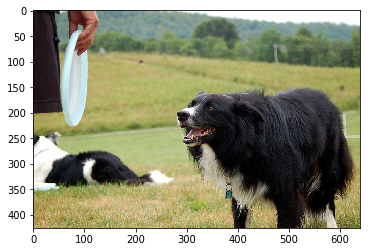

In [4]:
# extract the details of image with the image id
img = coco.loadImgs(imgIds[2])[0]
print(img)

# load the image using the location of the file listed in the image variable
I = io.imread('images/train2014/'+img['file_name'])

# display the image
plt.imshow(I)

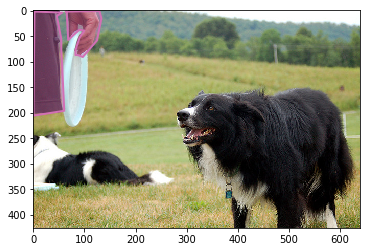

In [5]:
# display the image
plt.imshow(I)

# extract the annotation id 
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

# laod the annotation
anns = coco.loadAnns(annIds)

# plot the annotation on top of the image
coco.showAnns(anns)

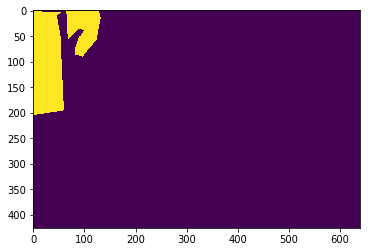

In [6]:
# build the mask for display with matplotlib
mask = coco.annToMask(anns[0])

# display the mask
plt.imshow(mask)

In [7]:
def data_list(imgIds, count = 12127, ratio = 0.2):
    """Function to load image and its target into memory."""
    img_lst = []
    lab_lst = []

    for x in tqdm(imgIds[0:count]):
        # load image details
        img = coco.loadImgs(x)[0]
        
        # read image
        I = io.imread('images/train2014/'+img['file_name'])
        if len(I.shape)<3:
            continue
        
        # load annotation information
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        
        # load annotation
        anns = coco.loadAnns(annIds)
        
        # prepare mask
        mask = coco.annToMask(anns[0])
        
        # This condition makes sure that we select images having only one person 
        if len(np.unique(mask)) == 2:
            
            # Next condition selects images where ratio of area covered by the 
            # person to the entire image is greater than the ratio paramater
            # This is done to not have large class imbalance
            if (len(np.where(mask>0)[0])/len(np.where(mask>=0)[0])) > ratio :
                
                # If you check, generated mask will have 2 classes i.e 0 and 2 
                # (0 - background/other, 1 - person).
                # to avoid issues with cv2 during the resize operation
                # set label 2 to 1, making label 1 as the person. 
                mask[mask==2] = 1
                
                # resize image and mask to shape (480, 360)
                I= cv2.resize(I, (480,360))
                mask = cv2.resize(mask, (480,360))

                # append mask and image to their lists
                img_lst.append(I)
                lab_lst.append(mask)
    return (img_lst, lab_lst)

img_lst, lab_lst = data_list(imgIds)

print('Sum of images for training, validation and testing :', len(img_lst))
print('Unique values in the labels array :', np.unique(lab_lst[0]))

100%|██████████| 12127/12127 [02:36<00:00, 77.27it/s]

Sum of images for training, validation and testing : 1997
Unique values in the labels array : [0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' Histogram Normalized Image')

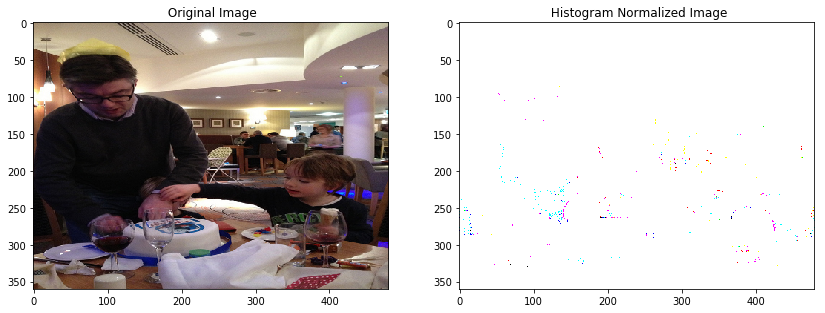

In [8]:
def make_normalize(img):
    """Function to histogram normalize images."""
    norm_img = np.zeros((img.shape[0], img.shape[1], 3),np.float32)

    b=img[:,:,0]
    g=img[:,:,1]
    r=img[:,:,2]

    norm_img[:,:,0]=cv2.equalizeHist(b)
    norm_img[:,:,1]=cv2.equalizeHist(g)
    norm_img[:,:,2]=cv2.equalizeHist(r)

    return norm_img

plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
plt.imshow(img_lst[5])
plt.title(' Original Image')
plt.subplot(1,2,2)
plt.imshow(make_normalize(img_lst[5]))
plt.title(' Histogram Normalized Image')

Text(0.5, 1.0, 'Person')

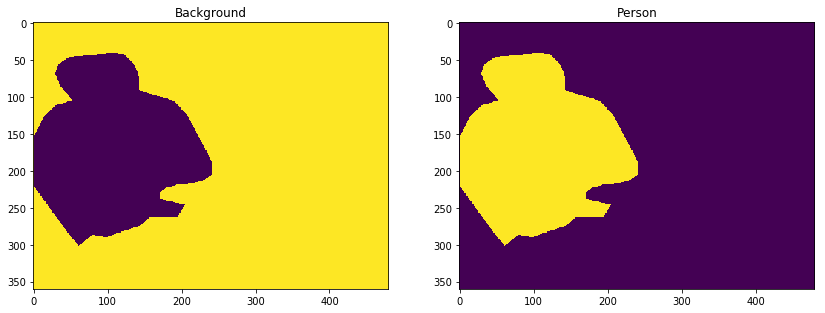

In [9]:
def make_target(labels):
    """Function to one hot encode targets."""
    x = np.zeros([360,480,2])
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
plt.imshow(make_target(lab_lst[5])[:,:,0])
plt.title('Background')
plt.subplot(1,2,2)
plt.imshow(make_target(lab_lst[5])[:,:,1])
plt.title('Person')

In [10]:
def model_data(images, labels):
    """Function to perform normalize and encode operation on each image."""
    # empty label and image list
    array_lst = []
    label_lst=[]
    
    # apply normalize function on each image and encoding function on each label
    for x,y in tqdm(zip(images, labels)):
        array_lst.append(np.rollaxis(make_normalize(x), 2))
        label_lst.append(make_target(y))
        
    return np.array(array_lst), np.array(label_lst)

# Get model data
train_data, train_lab = model_data(img_lst, lab_lst)

flat_image_shape = 360*480

# reshape target array
train_label = np.reshape(train_lab,(-1,flat_image_shape,2))

# test data
test_data = train_data[1900:]
# validation data
val_data = train_data[1500:1900]
# train data
train_data = train_data[:1500]

# test label
test_label = train_label[1900:]
# validation label
val_label = train_label[1500:1900]
# train label
train_label = train_label[:1500]

1997it [03:06, 10.76it/s]


In [11]:
# define optimizer
optimizer = Adam(lr=0.002)

# input shape to the model
input_shape=(3, 360, 480)

# training batchsize
batch_size = 6

# number of training epochs
nb_epoch = 60

In [12]:
model = Sequential()
# encoding
model.add(Layer(input_shape=input_shape))
model.add(ZeroPadding2D())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())

# decoding
model.add(ZeroPadding2D())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(UpSampling2D(size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(UpSampling2D(size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(UpSampling2D(size=(2,2)))

model.add(ZeroPadding2D())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=2, kernel_size=(1, 1), padding='valid'))

model.add(Reshape((2,flat_image_shape)))
model.add(Permute((2, 1)))
model.add(Activation('softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 3, 360, 480)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 362, 482)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 360, 480)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 360, 480)      1920      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 180, 240)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 182, 242)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 180, 240)     73856     
__________

In [14]:
# compile model
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.002), metrics=["accuracy"])

# use ReduceLROnPlateau to adjust the learning rate
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

callbacks_list = [reduceLROnPlat]

# fit the model
history = model.fit(train_data, train_label, callbacks=callbacks_list,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, shuffle = True, validation_data = (val_data, val_label))

Train on 1500 samples, validate on 400 samples
Epoch 1/60
1500/1500 [==============================] - 351s 234ms/step - loss: 0.6338 - acc: 0.6610 - val_loss: 0.6201 - val_acc: 0.6631
Epoch 2/60
1500/1500 [==============================] - 339s 226ms/step - loss: 0.6016 - acc: 0.6678 - val_loss: 0.6049 - val_acc: 0.6673
Epoch 3/60
1500/1500 [==============================] - 337s 225ms/step - loss: 0.5941 - acc: 0.6751 - val_loss: 0.6468 - val_acc: 0.5983
Epoch 4/60
1500/1500 [==============================] - 337s 225ms/step - loss: 0.5787 - acc: 0.6915 - val_loss: 0.5933 - val_acc: 0.6630
Epoch 5/60
1500/1500 [==============================] - 337s 225ms/step - loss: 0.5674 - acc: 0.7022 - val_loss: 0.5569 - val_acc: 0.7127
Epoch 6/60
1500/1500 [==============================] - 337s 225ms/step - loss: 0.5646 - acc: 0.7072 - val_loss: 0.7161 - val_acc: 0.6848
Epoch 7/60
1500/1500 [==============================] - 337s 225ms/step - loss: 0.5640 - acc: 0.7068 - val_loss: 0.5602 - val

In [34]:
history1 = model.fit(train_data, train_label, callbacks=callbacks_list,
           batch_size=batch_size, epochs=15,
           verbose=1, shuffle = True, validation_data = (val_data, val_label))

Train on 1500 samples, validate on 400 samples
Epoch 1/15
1500/1500 [==============================] - 340s 227ms/step - loss: 0.4386 - acc: 0.7874 - val_loss: 0.4903 - val_acc: 0.7608
Epoch 2/15
1500/1500 [==============================] - 340s 226ms/step - loss: 0.4359 - acc: 0.7888 - val_loss: 0.4923 - val_acc: 0.7613
Epoch 3/15
1500/1500 [==============================] - 339s 226ms/step - loss: 0.4318 - acc: 0.7903 - val_loss: 0.5310 - val_acc: 0.7562
Epoch 4/15
1500/1500 [==============================] - 340s 226ms/step - loss: 0.4336 - acc: 0.7899 - val_loss: 0.4901 - val_acc: 0.7573
Epoch 5/15
1500/1500 [==============================] - 339s 226ms/step - loss: 0.4282 - acc: 0.7935 - val_loss: 0.4884 - val_acc: 0.7627
Epoch 6/15
1500/1500 [==============================] - 339s 226ms/step - loss: 0.4259 - acc: 0.7942 - val_loss: 0.4859 - val_acc: 0.7630

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020022581156808883.
Epoch 7/15
1500/1500 [=====================

In [40]:
loss,acc = model.evaluate(test_data, test_label)
print('Loss :', loss)
print('Accuracy :', acc)

97/97 [==============================] - 6s 66ms/step
Loss : 0.4746804326465449
Accuracy : 0.7753429879847261


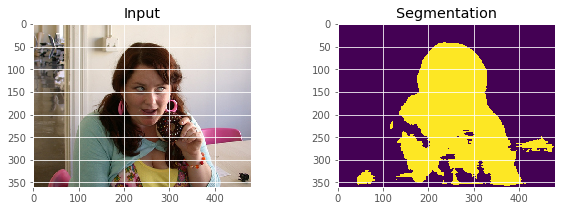

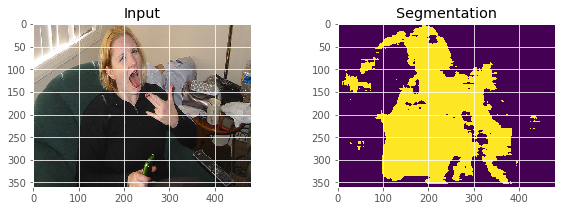

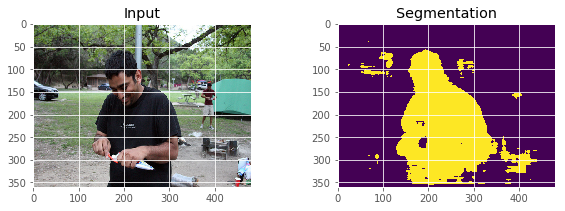

In [41]:
for i in range(3):
    plt.figure(figsize = (10,3))
    plt.subplot(1,2,1)
    plt.imshow(img_lst[1900+i])
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(model.predict_classes(test_data[i:(i+1)*1]).reshape(360,480))
    plt.title('Segmentation')